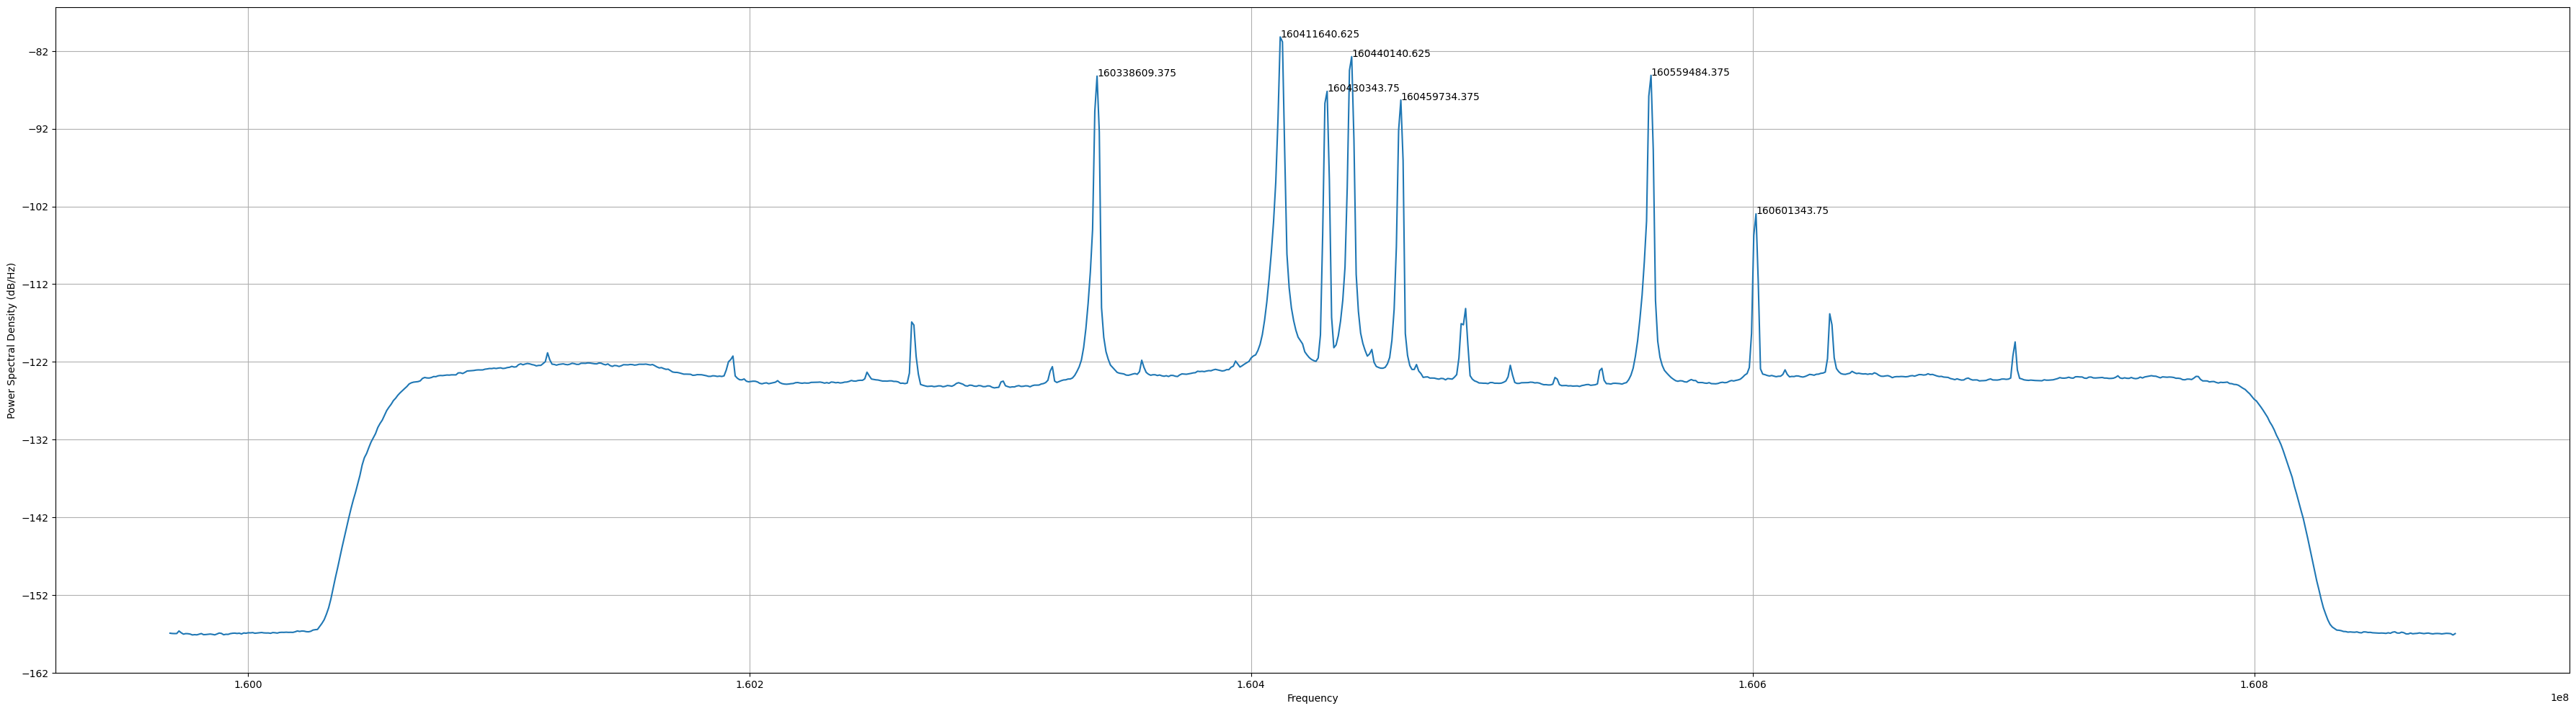

In [1]:
### MULTIPLE SIGNALS
### CENTER 160425000

# SIGNALS ON
# 160340000 - exact freq 160338609 
# 160410000 - exact freq on 160411640
# Fc DC spike on 160430343 
# 160440000 - exact freq on 160440140
# 160460000 - exact freq on 160459734

from scipy.io import wavfile
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt

samples = np.fromfile('../data/test_multiple.fc32', dtype=np.complex64)
sample_rate = 912000
center_freq = 160425000
samples = samples[0:5000000]
size = len(samples)
x = samples

x[(len(x) // 2 - 10):(len(x) // 2 + 10)] = np.mean(x[(len(x) // 2) - 10 : (len(x) // 2) + 10])


# PLOT THE PSD
fft_freqs = np.linspace(sample_rate / -2, sample_rate / 2, 1024) + center_freq
plt.figure(figsize=(45,12))
psd = plt.psd(x, NFFT=1024, Fs=912000, Fc=160425000)
peaks = signal.find_peaks(psd[0], prominence=0.00000000001)
for peak, prominence in zip(peaks[0], peaks[1]["prominences"]):
    peak_freq =  ((peak/1024)*sample_rate) + (center_freq-(sample_rate/2))
    plt.annotate(peak_freq, xy=( peak_freq , 10 * np.log10(prominence)))
plt.show()

In [ ]:
"""
# pfb.py

Simple implementation of a polyphase filterbank.
"""
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter


def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

def pfb_fir_frontend(x, win_coeffs, M, P):
    W = x.shape[0] // M // P
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M + 1))
    for t in range(0, M*W-M + 1):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

def fft(x_p, P, axis=1):
    return np.fft.fft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x = x[:int(len(x)//(M*P))*M*P] # Ensure it's an integer multiple of win_coeffs
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)
    pg = np.sum(np.abs(win_coeffs)**2)
    win_coeffs /= pg**.5 # Normalize for processing gain
    
    # Apply frontend, take FFT, then take power (i.e. square)
    x_pfb = pfb_filterbank(x, win_coeffs, M, P)
    x_psd = np.real(x_pfb * np.conj(x_pfb))
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

if __name__ == "__main__":
    import pylab as plt
    import seaborn as sns
    sns.set_style("white")
    
    M     = 4          # Number of taps
    P     = 1024       # Number of 'branches', also fft length
    W     = 1000       # Number of windows of length M*P in input time stream
    n_int = 10          # Number of time integrations on output data

    # Generate a test data steam
    #samples = np.arange(M*P*W)
    #noise   = np.random.normal(loc=0.5, scale=0.1, size=M*P*W) 
    #freq    = 1
    #amp     = 1
    #cw_signal = amp * np.sin(samples * freq)
    #data = noise + cw_signal
    data = np.fromfile('data/test_multiple.fc32', dtype=np.complex64)

    
    X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=2, window_fn="hamming")

    plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel("Channel")
    plt.ylabel("Time")
    
    plt.show()
    


